In [1]:
%load_ext autoreload
%load_ext memory_profiler
%matplotlib inline

In [8]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from tempest import casestudy
from tempest import grid
from tempest import storm_tracker
from tempest import joint_distrib
from tempest import handler
settings_path = 'settings/tropics_old_grid.yaml'

In [9]:
# Instantiate CaseStudy by passing the settings. 
# Should also create appropriate directories
hdlr = handler.Handler(settings_path)
cs = casestudy.CaseStudy(hdlr, overwrite = False ,verbose = False)
gr = grid.Grid(cs, fast = True, overwrite= False, verbose_steps = False, verbose = False)
st = storm_tracker.StormTracker(gr, overwrite = False) #overwrite = True is super long
# jd = joint_distrib.JointDistribution(gr, st)

Data loaded from /homedata/mcarenso/tempest/DYAMOND_SAM_Tropics_old_grid/var_id_days_i_t.json
Found grid attributes file , so loading /homedata/mcarenso/tempest/DYAMOND_SAM_Tropics_old_grid/grid_attributes.pkl instead of computing
Loading storms...
loading storms from pkl
Time elapsed for loading storms: 49.42 seconds


In [10]:
gr.get_var_id_ds("MCS_label")

<xarray.Dataset>
Dimensions:            (MCS: 300, lat_global: 60, lon_global: 360, days: 40)
Coordinates:
  * MCS                (MCS) int64 0 1 2 3 4 5 6 ... 293 294 295 296 297 298 299
  * days               (days) object '16-08-01' '16-08-02' ... '16-09-09'
  * lat_global         (lat_global) int64 0 1 2 3 4 5 6 ... 53 54 55 56 57 58 59
  * lon_global         (lon_global) int64 0 1 2 3 4 5 ... 355 356 357 358 359
Data variables:
    MCS_label          (lat_global, lon_global, days, MCS) float64 ...
    global_pixel_surf  (lat_global, lon_global, days) float64 ...
Attributes:
    history:  Sat Dec 16 10:32:12 2023: ncks -d days,0,39 /homedata/mcarenso/...
    NCO:      netCDF Operators version 4.9.1 (Homepage = http://nco.sf.net, C...

In [11]:
prec = gr.get_var_id_ds("Prec")
prec

<xarray.Dataset>
Dimensions:            (lat_global: 60, lon_global: 360, days: 40)
Coordinates:
  * lat_global         (lat_global) int64 0 1 2 3 4 5 6 ... 53 54 55 56 57 58 59
  * lon_global         (lon_global) int64 0 1 2 3 4 5 ... 355 356 357 358 359
  * days               (days) object '16-08-01' '16-08-02' ... '16-09-09'
Data variables:
    global_pixel_surf  (lat_global, lon_global, days) float64 ...
    max_Prec           (lat_global, lon_global, days) float64 ...
    mean_Prec          (lat_global, lon_global, days) float64 ...

### plot hist, to add to Distribution

In [12]:
def simple_hist(X, name, bounds= None, mean_and_std = True, fig=None, ax=None):
    X_mean = np.nanmean(X)
    X_std = np.nanstd(X)
    if ax==None and fig ==None : 
        fig, ax = plt.subplots(1, 1)
    # Create histogram with manually adjusted bins
    bins = int(np.sqrt(len(X)))
    if bounds == None :
        bounds = (np.nanmin(X), np.nanmax(X))
    ax.hist(X, bins=bins, edgecolor='black', range = bounds, alpha=0.7)

    # Add mean and standard deviation to the plot
    if mean_and_std:
        ax.axvline(X_mean, color='red', linestyle='dashed', linewidth=2, label=f'Mean: {X_mean:.2f}')
        ax.axvline(X_mean + X_std, color='green', linestyle='dashed', linewidth=2, label=f'Std Dev: {X_std:.2f}')
        ax.axvline(X_mean - X_std, color='green', linestyle='dashed', linewidth=2)

    # Add labels and title
    ax.set_xlabel(name)
    ax.set_ylabel('Frequency')
    ax.set_title("Histogram of "+name)

# Load Joint Distribs

In [5]:
jd_mean_heavy = joint_distrib.JointDistribution(gr, st, nd = 5, var_id_1 = "mean_Prec", var_id_2 = "heavy_Prec", overwrite = True)
jd_mean_supra = joint_distrib.JointDistribution(gr, st, nd = 5, var_id_1 = "mean_Prec", var_id_2 = "supra_Prec", overwrite = True)
jd_mean_ultra = joint_distrib.JointDistribution(gr, st, nd = 5, var_id_1 = "mean_Prec", var_id_2 = "ultra_Prec", overwrite = True)
jd_mean_max = joint_distrib.JointDistribution(gr, st, nd=5, var_id_1 = "mean_Prec", var_id_2 = "max_Prec", overwrite =True, regionalize=False)
jd_mean_convective = joint_distrib.JointDistribution(gr, st, nd = 5, var_id_1 = "mean_Prec", var_id_2 = "convective_Prec", overwrite = True)
jds_mean = [jd_mean_heavy, jd_mean_supra, jd_mean_ultra, jd_mean_max, jd_mean_convective]

jd_wet_heavy = joint_distrib.JointDistribution(gr, st, nd = 5, var_id_1 = "wet_Prec", var_id_2 = "heavy_Prec", overwrite = True)
jd_wet_supra = joint_distrib.JointDistribution(gr, st, nd = 5, var_id_1 = "wet_Prec", var_id_2 = "supra_Prec", overwrite = True)
jd_wet_ultra = joint_distrib.JointDistribution(gr, st, nd = 5, var_id_1 = "wet_Prec", var_id_2 = "ultra_Prec", overwrite = True)
jd_wet_max = joint_distrib.JointDistribution(gr, st, nd=5, var_id_1 = "wet_Prec", var_id_2 = "max_Prec", overwrite =True, regionalize=False)
jd_wet_convective = joint_distrib.JointDistribution(gr, st, nd = 5, var_id_1 = "wet_Prec", var_id_2 = "convective_Prec", overwrite = True)
jds_wet = [jd_wet_heavy, jd_wet_supra, jd_wet_ultra, jd_wet_max, jd_wet_convective]

jds = jds_mean + jds_wet

# oh la chelou
jd_mean_wet = joint_distrib.JointDistribution(gr, st, nd = 5, var_id_1 = "mean_Prec", var_id_2 = "wet_Prec", overwrite = True)


Distribs have been recomputed because overwrite is set to True
Overwrite set to true, so computing basics and saving them
Time elapsed for propagating all labels: 5.70 seconds
Distribs have been recomputed because overwrite is set to True
Overwrite set to true, so computing basics and saving them
Time elapsed for propagating all labels: 5.73 seconds
Distribs have been recomputed because overwrite is set to True
Overwrite set to true, so computing basics and saving them
Time elapsed for propagating all labels: 5.81 seconds
Distribs have been recomputed because overwrite is set to True
Overwrite set to true, so computing basics and saving them
Time elapsed for propagating all labels: 5.79 seconds
Distribs have been recomputed because overwrite is set to True
Overwrite set to true, so computing basics and saving them
Time elapsed for propagating all labels: 2.54 seconds
Distribs have been recomputed because overwrite is set to True
Overwrite set to true, so computing basics and saving the

# Show Bincounts

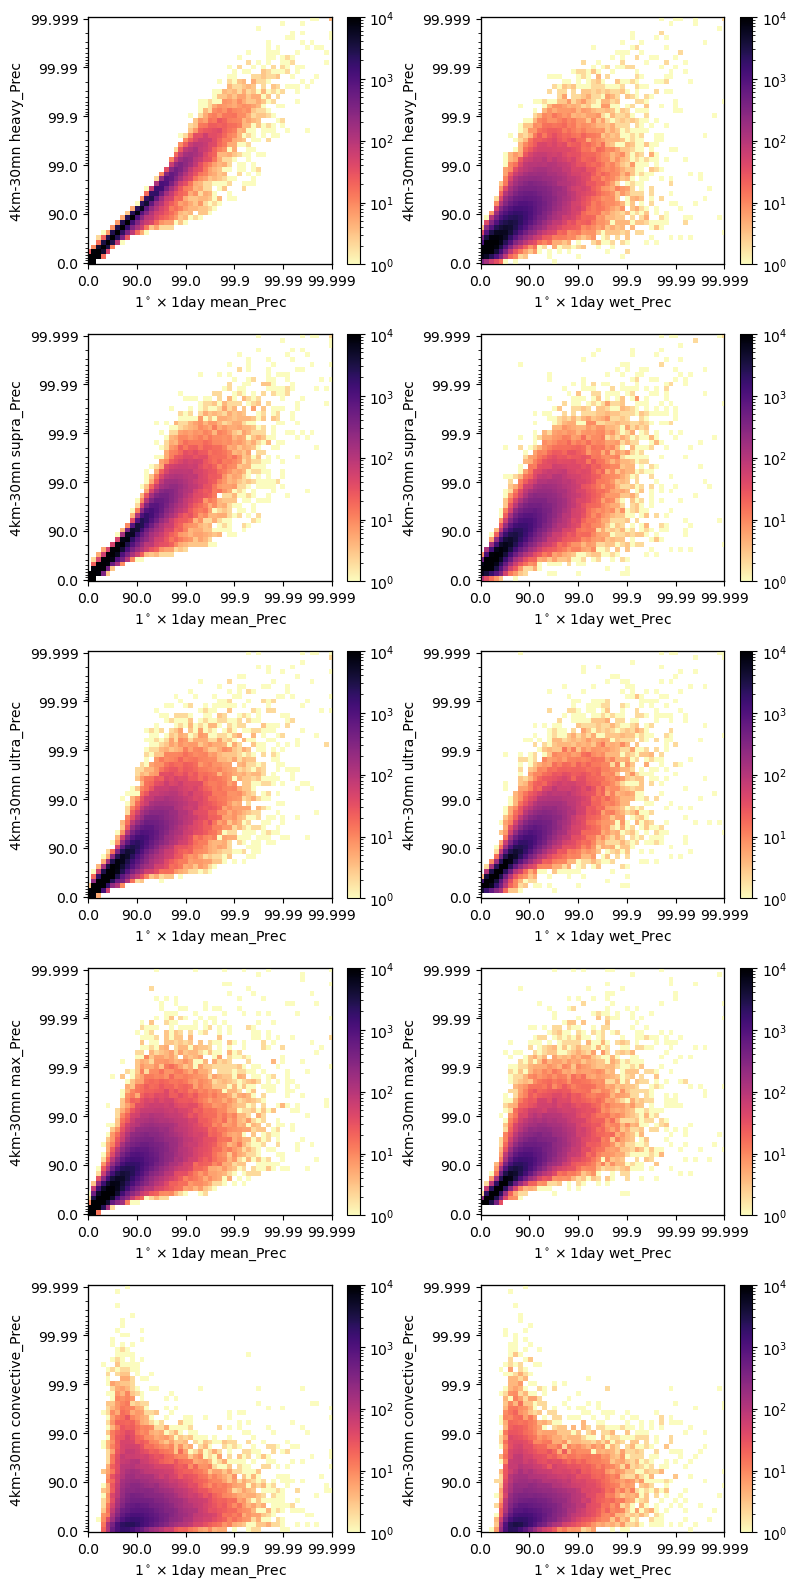

In [6]:
%matplotlib inline
fig, axs = plt.subplots(nrows = 5, ncols =2, figsize = (8, 16))
for jd_mean, ax_mean, jd_wet, ax_wet in zip(jds_mean, axs[:,0], jds_wet, axs[:,1]):
    # Left side
    jd_mean.plot_data(jd_mean.bincount, scale = 'log', cmap=plt.cm.magma_r , fig =fig, ax = ax_mean, vbds = (1, 1e4))
    # Right side
    jd_wet.plot_data(jd_wet.bincount, scale = 'log', cmap =plt.cm.magma_r, fig=fig, ax=ax_wet, vbds=(1, 1e4))
    
plt.tight_layout()

<AxesSubplot:xlabel='1$^\\circ\\times 1$day mean_Prec', ylabel='4km-30mn wet_Prec'>

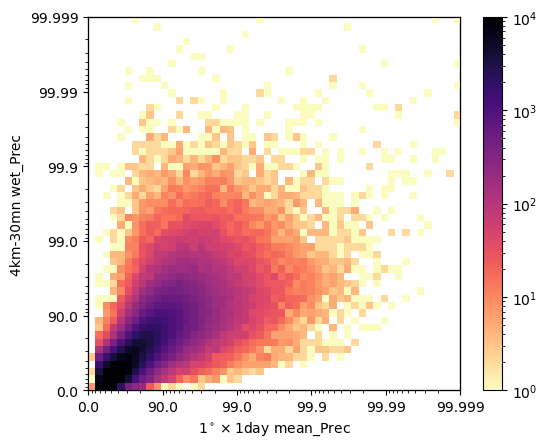

In [185]:
%matplotlib inline
jd_mean_wet.plot_data(jd_mean_wet.bincount, scale = 'log', cmap=plt.cm.magma_r, vbds = (1, 1e4))

# Show Normalized Density

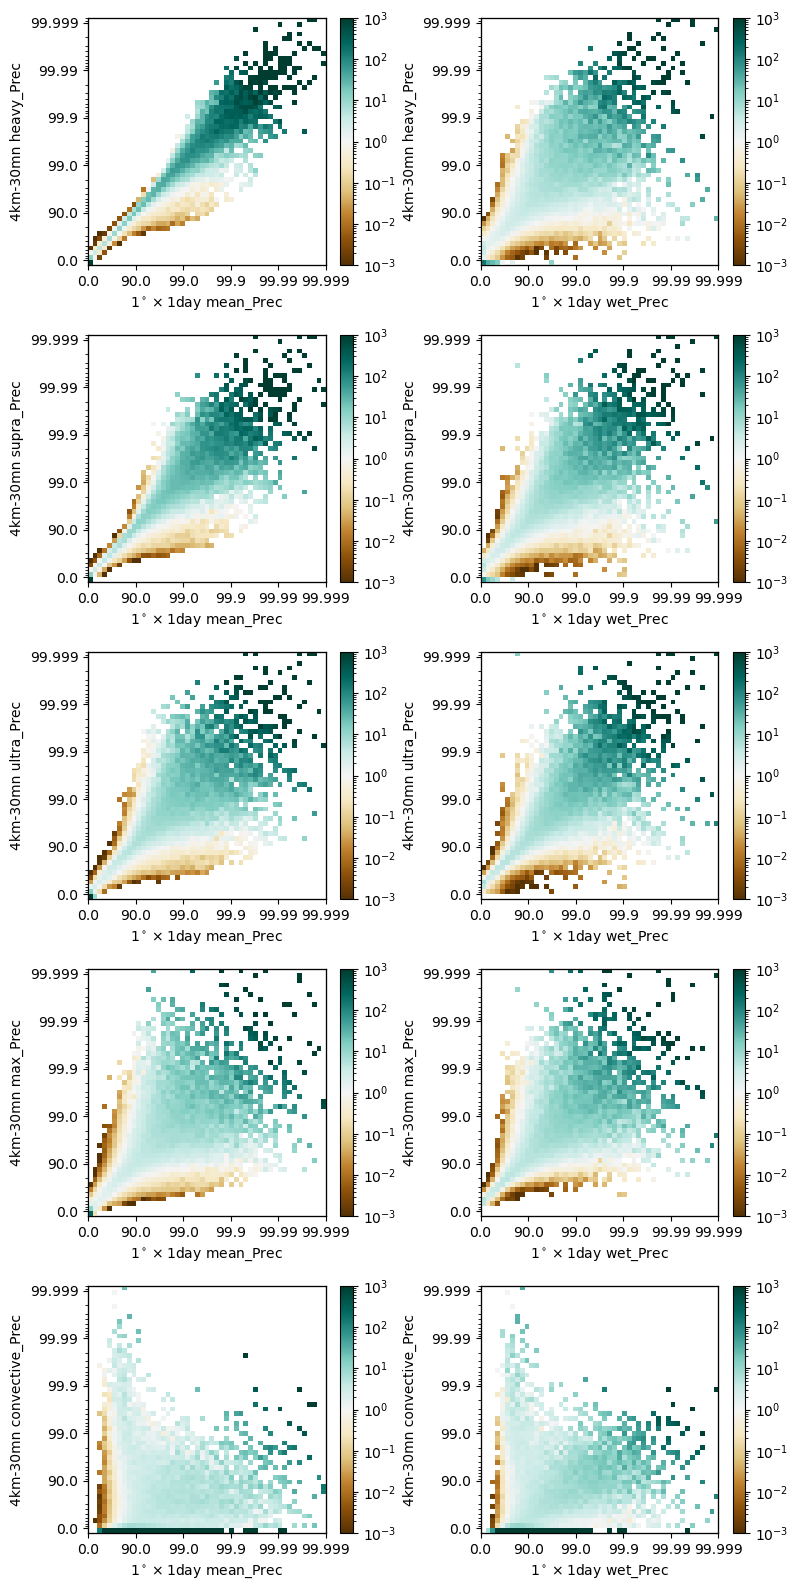

In [188]:
%matplotlib inline
fig, axs = plt.subplots(nrows = 5, ncols =2, figsize = (8, 16))
for jd_mean, ax_mean, jd_wet, ax_wet in zip(jds_mean, axs[:,0], jds_wet, axs[:,1]):
    # Left side
    jd_mean.plot_data(jd_mean.norm_density, scale = 'log', cmap=plt.cm.BrBG , fig =fig, ax = ax_mean, vbds = (1e-3,1e3))
    # Right side
    jd_wet.plot_data(jd_wet.norm_density, scale = 'log', cmap=plt.cm.BrBG, fig=fig, ax=ax_wet, vbds=(1e-3,1e3))
    
plt.tight_layout()

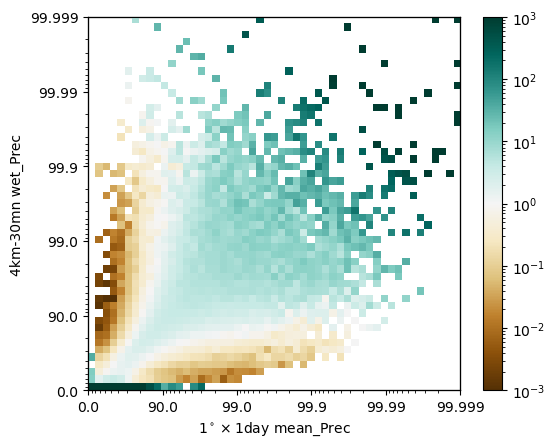

In [190]:
%matplotlib inline
jd_mean_wet.plot_data(jd_mean_wet.norm_density, scale = 'log', cmap=plt.cm.BrBG, vbds=(1e-3,1e3))
plt.show()

# Mutual Information

In [191]:
import math

def mutual_information(self, treshold=10):
    mi_pos = 0
    mi_neg = 0
    l1, l2 = len(self.bins1)-1, len(self.bins2)-1
    for i in range(treshold, l1):
        for j in range(treshold, l2):
            if self.norm_density[i,j] != 0 : 
                mi_ij = self.density[i,j]*math.log10(self.norm_density[i,j])
                if mi_ij >0:
                    mi_pos+=mi_ij
                else:
                    mi_neg+=mi_ij
            else : 
                pass
                
    return mi_pos+mi_neg, mi_pos, mi_neg

### For mean_Precip with treshold 10

Text(0.5, 1.0, 'Mean precip vs heavy, supra, ultra, max, convective(?), with treshold at 10th bins')

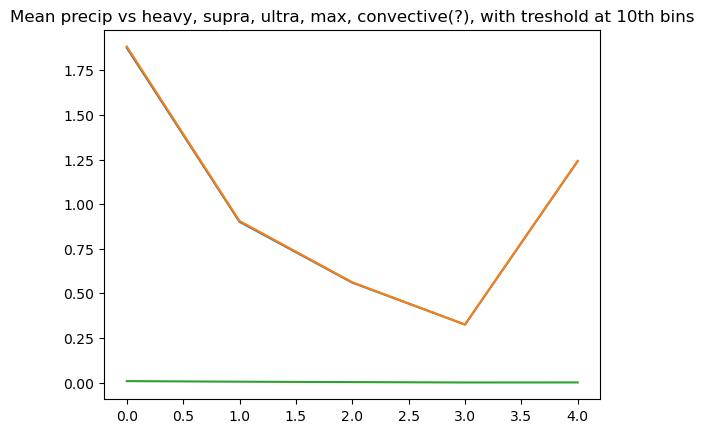

In [230]:
mean_mi = []
mean_mi_pos = []
mean_mi_neg = []
for jd_mean in jds_mean:
    mi = mutual_information(jd_mean)
    mean_mi.append(mi[0])
    mean_mi_pos.append(mi[1])
    mean_mi_neg.append(-mi[2])
plt.plot(mean_mi)
plt.plot(mean_mi_pos)
plt.plot(mean_mi_neg)
plt.title("Mean precip vs heavy, supra, ultra, max, convective(?), with treshold at 10th bins")

### same but no treshold

Text(0.5, 1.0, 'Mean precip vs heavy, supra, ultra, max, convective(?), with treshold at 10th bins')

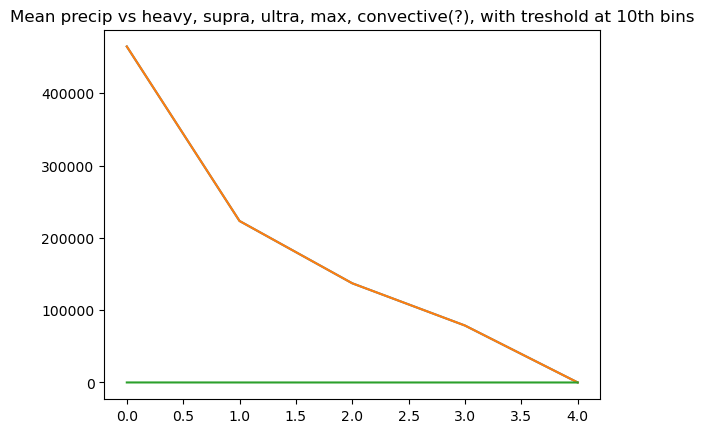

In [231]:
mean_mi = []
mean_mi_pos = []
mean_mi_neg = []
treshold = 0
for jd_mean in jds_mean:
    mi = mutual_information(jd_mean, treshold)
    mean_mi.append(mi[0])
    mean_mi_pos.append(mi[1])
    mean_mi_neg.append(-mi[2])
    
plt.plot(mean_mi)
plt.plot(mean_mi_pos)
plt.plot(mean_mi_neg)
plt.title("Mean precip vs heavy, supra, ultra, max, convective(?), with treshold at 10th bins")

### For wet Precip with treshold at 10th bin

Text(0.5, 1.0, 'Wet precip vs heavy, supra, ultra, max, convective(?), with treshold at 10th bins')

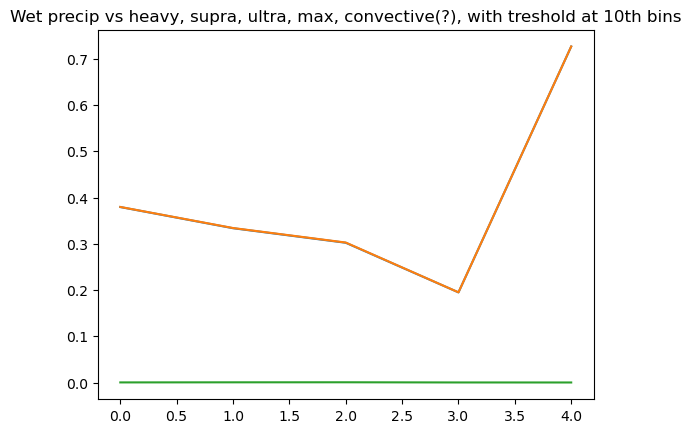

In [232]:
mean_mi = []
mean_mi_pos = []
mean_mi_neg = []
treshold = 10
for jd in jds_wet:
    jd.compute_joint_density(jd.sample1, jd.sample2)
    mi = mutual_information(jd, treshold)
    mean_mi.append(mi[0])
    mean_mi_pos.append(mi[1])
    mean_mi_neg.append(-mi[2])
    
plt.plot(mean_mi)
plt.plot(mean_mi_pos)
plt.plot(mean_mi_neg)
plt.title("Wet precip vs heavy, supra, ultra, max, convective(?), with treshold at 10th bins")

## For wet precip no treshold

Text(0.5, 1.0, 'Wet precip vs heavy, supra, ultra, max, convective(?), with no bins treshold')

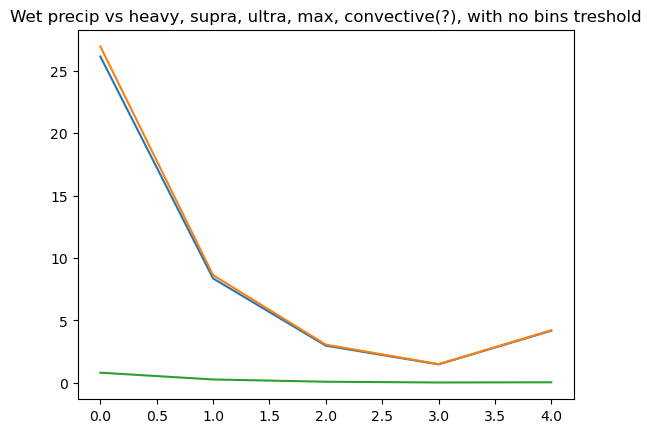

In [233]:
mean_mi = []
mean_mi_pos = []
mean_mi_neg = []
treshold = 0
for jd in jds_wet:
    # jd.compute_joint_density(jd.sample1, jd.sample2)
    mi = mutual_information(jd, treshold)
    mean_mi.append(mi[0])
    mean_mi_pos.append(mi[1])
    mean_mi_neg.append(-mi[2])
    
plt.plot(mean_mi)
plt.plot(mean_mi_pos)
plt.plot(mean_mi_neg)
plt.title("Wet precip vs heavy, supra, ultra, max, convective(?), with no bins treshold")

# Plot alphas

### Process weird values (outrageously negative or way too high. Seems to only happend for relatives treshold, either due to np.percentile behvaior, or subsequent indexing)

#

In [108]:
alpha_names = ["Alpha_1mm_per_h", "Alpha_95", "Alpha_99", "Alpha_99_99", "Alpha_99_99_native"]
jds_alpha = [jd_mean_wet, jd_mean_heavy, jd_mean_supra, jd_mean_ultra, jd_mean_convective]
alphas_on_density = []
for alpha, jd in zip(alpha_names, jds_alpha):
    if alpha=="Alpha_95" : 
        mask = (prec[alpha].values < 0) | (prec[alpha].values > 50)
        prec[alpha].values[mask] = np.nan
        clean_alpha = prec[alpha].values
    elif alpha == "Alpha_99":
        mask = (prec[alpha].values < 0) | (prec[alpha].values > 30)
        prec[alpha].values[mask] = np.nan
        clean_alpha = prec[alpha].values
    elif alpha == "Alpha_99_99":
        mask = (prec[alpha].values < 0) | (prec[alpha].values > 10)
        prec[alpha].values[mask] = np.nan
        clean_alpha = prec[alpha].values
    else : 
        clean_alpha =  prec[alpha].values

    alphas_on_density.append(jd.compute_conditional_data_over_density(jd.sample1, jd.sample2, clean_alpha))

<class 'numpy.ndarray'>


/home/mcarenso/code/tempest/tempest/joint_distrib.py:372: RuntimeWarning: Mean of empty slice
  data_over_density[i1, i2] = np.nanmean(data.flatten()[data_idx])


<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


### Alpha values on their according joint distrib vs Mean Precip + thier histogram for understanding bounds choice

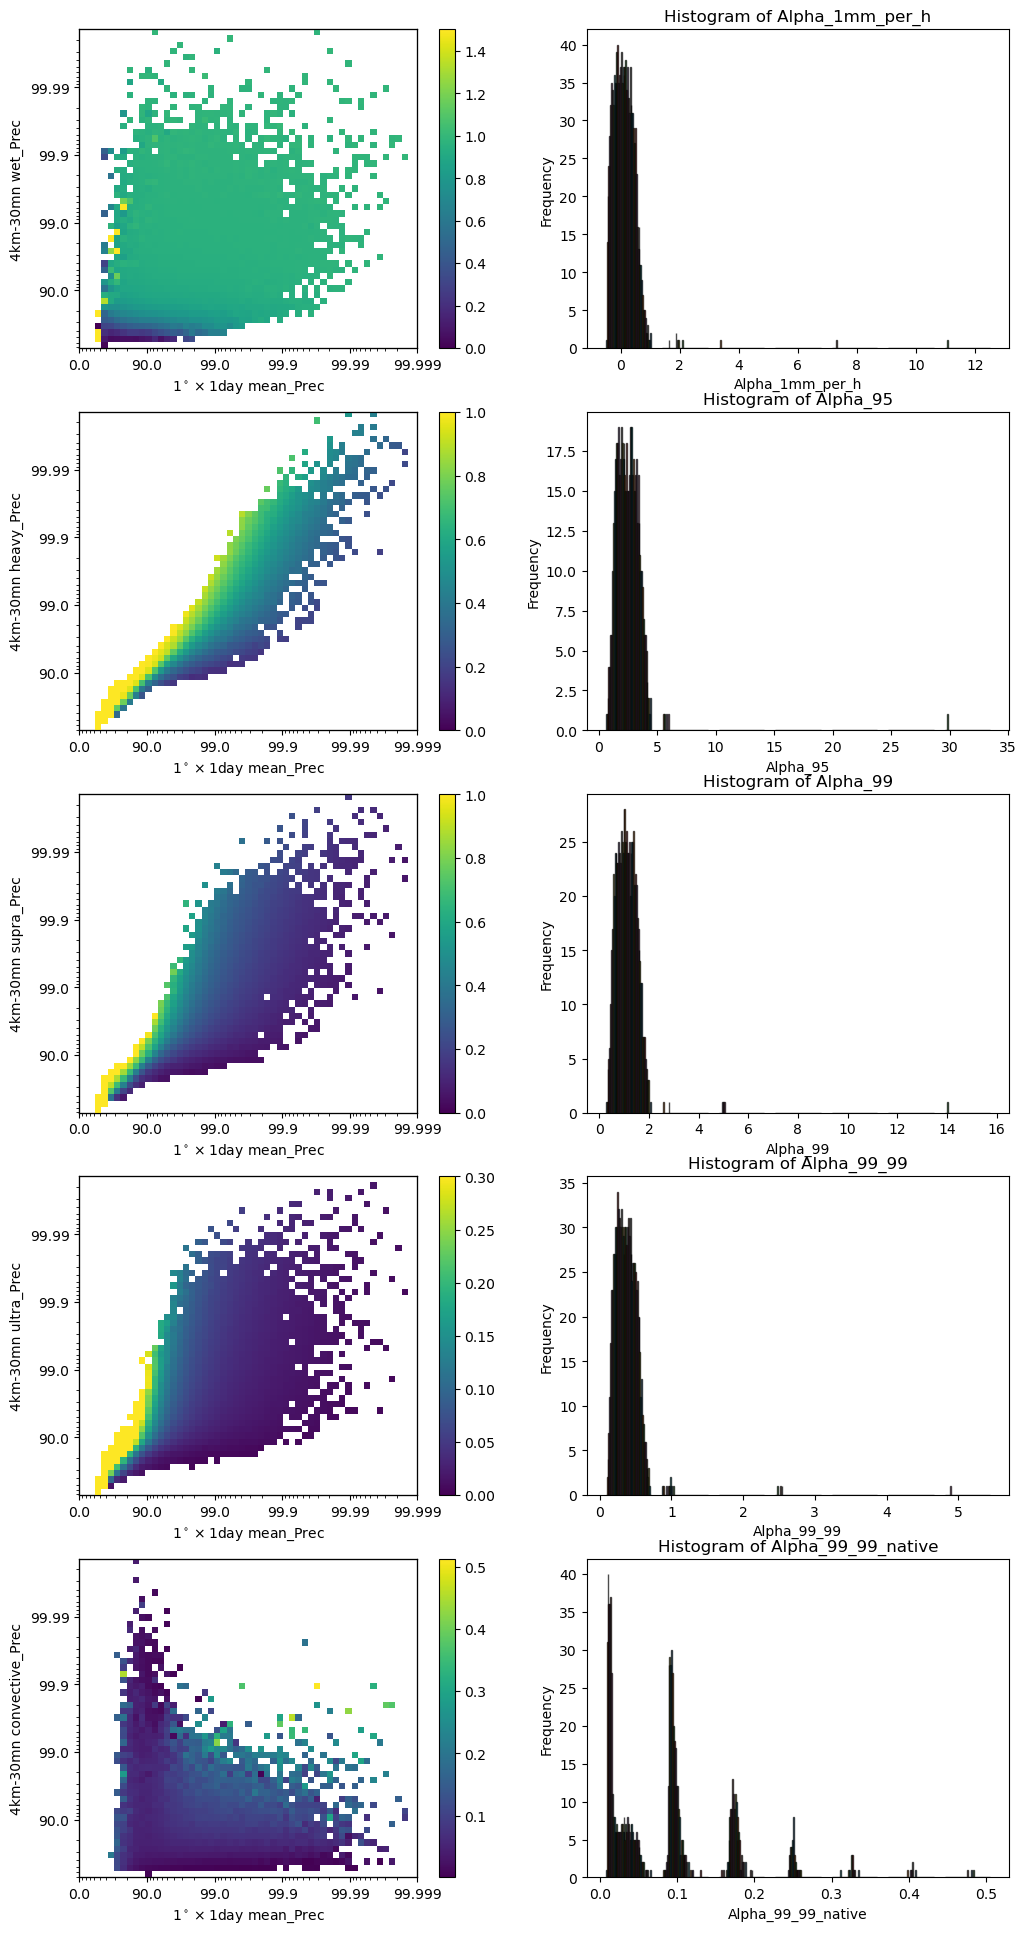

In [143]:
fig, axs = plt.subplots(nrows = 5, ncols=2, figsize=(12,24))
alphas_vbds = [(0, 1.5), (0, 1), (0,1), (0, 0.3), (None, None)]
for jd, alpha, ax, vbds, ax_hist, name in zip(jds_alpha, alphas_on_density, axs[:,0].flatten(), alphas_vbds, axs[:,1].flatten(),alpha_names):
    jd.plot_data(alpha, fig = fig, ax = ax, cmap = plt.cm.viridis, vbds=vbds)
    simple_hist(alpha, name, fig = fig, ax = ax_hist, mean_and_std=False)

#### Native (regridded) alpha hist for processing purposes

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


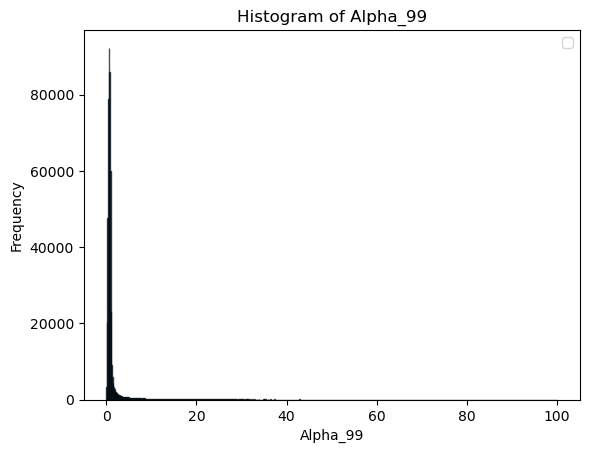

In [100]:
alpha_95 = np.sort(prec["Alpha_99"].values.flatten())
simple_hist(alpha_95, "Alpha_99", bounds = (0, 100), mean_and_std=False)

# To add to tempest.plots